# **HW2**
**NAME:** JANGA TUSHITA SHARVA  
**ROLL NUMBER:** CS21BTECH11022

In [21]:
# Libraries import
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

### **QUESTION 1: DISTANCE BETWEEN PDFs**

### 1A: Cross Entropy

Helper functions

In [22]:
ERROR_UNEQUAL_SPACES = -1
ERROR_INVALID_PMF = -2
ERROR_INF_DIVERGENCE = np.inf

def get_entropy(distr): # Computes entropy given probability distribution
    if not np.isclose(np.sum(distr), 1):
        print(ERROR_INVALID_PMF)
        return ERROR_INVALID_PMF

    entropy = 0.0
    for i in distr:
        if i > 0.0:
            entropy -= i * np.log2(i)
    return entropy

def get_normalized_historgram_of_image(filepath):
    img = np.asarray(Image.open(filepath))
    freq = np.zeros(256)
    num_pixels = img.size
    for i in img:
        for j in i:
            freq[j] += 1
    freq = freq/num_pixels
    
    return freq

def get_kl_divergence(distr1, distr2):
    divergence = 0.0
    n1 = distr1.shape
    n2 = distr2.shape

    if(n1 != n2):
        return ERROR_UNEQUAL_SPACES
    
    for i in range(n1[0]):
        if distr1[i] > 0.0 and distr2[i] > 0.0:
            divergence += distr1[i] * np.log2(distr1[i]/distr2[i])
        elif distr2[i] == 0.0 and distr1[i] != 0.0:
            return ERROR_INF_DIVERGENCE

    return divergence

### (i)

In [23]:
# Function for finding cross entropy
def get_cross_entropy(p, q):
    ENT = get_entropy(p)
    DIV = get_kl_divergence(p, q)
    return ENT+DIV

p = get_normalized_historgram_of_image('left.png')
q = get_normalized_historgram_of_image('right.png')

print(get_cross_entropy(p,q))
print(get_cross_entropy(q,p))

7.273398119987328
7.293035317529478


### (ii)

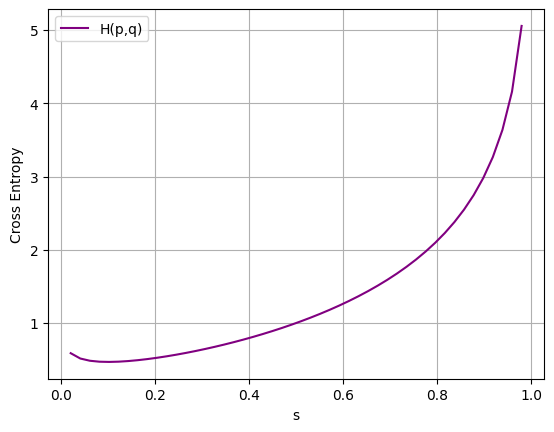

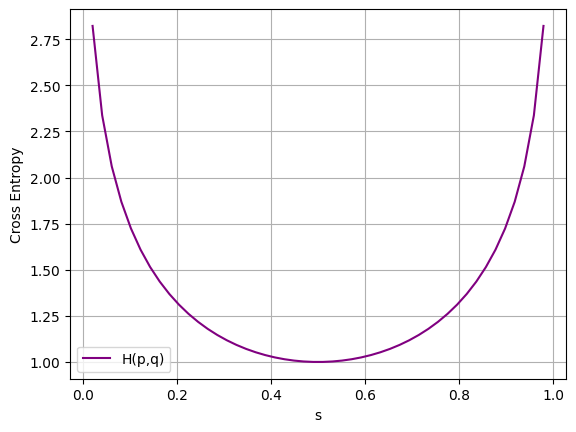

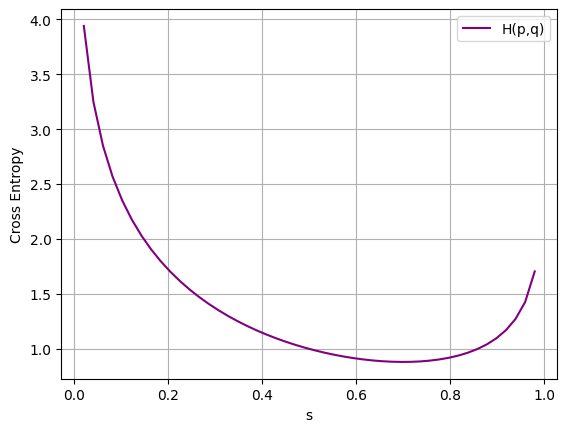

In [24]:
def plot_cross_entropy(r):
    s_space = np.linspace(0, 1)
    cross_entropy_pq = []

    for s in s_space:
        p = np.array([r, 1-r])
        q = np.array([s, 1-s])
        cross_entropy_pq.append(get_cross_entropy(p, q))
        
    plt.plot(s_space, cross_entropy_pq, color='purple', label='H(p,q)')
    plt.grid(True)
    plt.xlabel('s')
    plt.ylabel('Cross Entropy')
    plt.legend()
    plt.show()

plot_cross_entropy(0.1)
plot_cross_entropy(0.5)
plot_cross_entropy(0.7)

Yes, as we can see from the above, a minimum is obtained when both the PMFs match.

### 1B: JS Divergence

In [25]:
def get_js_divergence(p, q):
    m = (p + q)/2
    return 0.5 * (get_kl_divergence(p , m) + get_kl_divergence(q, m))

p = get_normalized_historgram_of_image('left.png')
q = get_normalized_historgram_of_image('right.png')

print(f'JS divergence for (L, R) = {get_js_divergence(p,q)}')
print(f'JS divergence for (R, L) = {get_js_divergence(q,p)}')
print(f'KL divergence for (L, R) = {get_kl_divergence(p,q)}')
print(f'KL divergence for (R, L) = {get_kl_divergence(q,p)}')

JS divergence for (L, R) = 0.0036730397693148257
JS divergence for (R, L) = 0.0036730397693148257
KL divergence for (L, R) = 0.015104015237387055
KL divergence for (R, L) = 0.014409785833354494


Hence verified that KL divergence is not symmetric whereas JS divergence is

### 1C: Wasserstein Distance

In [26]:
# This uses loops, can have poor performance
def check_joint_histogram(pXY, rX, sY):
    rows = len(pXY)
    cols = len(pXY[0])

    computed_rX = [0] * rows
    computed_sY = [0] * cols
    
    # Marginal rX
    for row in range(rows):
        for col in range(cols):
            computed_rX[row] += pXY[row][col]
            computed_sY[col] += pXY[row][col]
            
    for i in range(rows):
        if not np.isclose(computed_rX[i], rX[i]):
            return False
    
    for j in range(cols):
        if not np.isclose(computed_sY[j], sY[j]):
            return False
    
    return True

# Optimised version, using np sum
def check_joint_histogram_opt(pXY, rX, sY):

    computed_sY = np.sum(pXY, axis=0)
    computed_rX = np.sum(pXY, axis=1)
    
    if np.allclose(computed_rX, rX) and np.allclose(computed_sY, sY):
        return True
    else:
        return False


# Positive Sample
pXY = [[0.2, 0.1], [0.3, 0.4]]
rX = [0.3, 0.7]
sY = [0.5, 0.5]
# print(check_joint_histogram(pXY, rX, sY))
print(check_joint_histogram_opt(pXY, rX, sY))

# Negative Sample
pXY = [[0.2, 0.1], [0.3, 0.4]]
rX = [0.4, 0.6]
sY = [0.5, 0.5]
# print(check_joint_histogram(pXY, rX, sY))
print(check_joint_histogram_opt(pXY, rX, sY))

True
False


### **QUESTION 2: VISUALIZING DATA USING t-SNE**

### 2A

1. **Crowding problem:** It is the problem of mapping high dimensional data to the low dimensional data, without losing important distance relationships between the points. Distant points in the high-dimensional space would have almost zero similarity in the low-dimensional embedding. This would lead to those points being placed too close to each other, known as crowding problem.

2. **Student t-distribution:** The student t-distribution has heavier tails, which means that in the low dimensional space, the points are relativelt far apart in the low dimensional space. By heavier tails, we mean that more mass is concentrated at the either sides of bell shape of the distribution. This means that extreme values occur more frequently. This means that we obtain non-negligible similarity values for distant points. This would prevent all the distant points crowding in one place.

3. Changes made to t-SNE are:
    - Using symmetric stochastic neighbourhood embedding to compute joint distributions of higher dimensional and lower dimensional spaces instead of conditional distributions
    - Using Cauchy-Like (or student t-distribution) instead of Gaussian
    - Multiplying $p_{ij}$ with a constant, so that the low dimensional mapping gives more separated clusters.

### 2B

In [27]:
# Generating clusters
n = 100
cluster_1 = np.random.multivariate_normal(np.ones(10), 0.01 * np.eye(10), n)
cluster_2 = np.random.multivariate_normal(np.ones(10), 0.01 * np.eye(10), n)

cluster = np.concatenate((cluster_1, cluster_2), axis=0)

In [28]:
class simple_tSNE():
    def __init__(self, iters, learning_rate, momentum):
        self.iters = iters
        self.learning_rate = learning_rate
        self.momentum = momentum
    
    def get_pairwise_squared_distance(self, data): # Will be used while computing affinities
        n = data.shape[0]
        distance = np.zeros((n, n)) # Initializing distance matrix
        for i in range(n):
            for j in range(n):
                diff = data[i] - data[j]
                distance[i, j] = np.sum(diff ** 2)

        return distance
    
    def get_high_dimensional_affinities(self, data): # For computing pairwise affinities required for line 6 of algorithm
        dist = self.get_pairwise_squared_distance(data)
        p = np.exp((dist * -1)/(2 * 0.01))
        np.fill_diagonal(p, 0)
        p /= np.sum(p, axis=1, keepdims=True)
        p = (p + p.T)/(2 * p.shape[0])
        return p
    
    def get_low_dimensional_affinities(self, y): # For line 10 of the algorithm
        dist = self.get_pairwise_squared_distance(y)
        q = 1/(1+dist)
        np.fill_diagonal(q, 0)
        q /= np.sum(q)
        return q

    def get_gradient(self, p, q, y):
        dist = self.get_pairwise_squared_distance(y)
        inv_dist = 1 / (1 + dist)

        gradient = np.zeros_like(y)
        for i in range(gradient.shape[0]):
            diff = y[i] - y
            const = (p[i] - q[i]) * inv_dist[i]
            gradient[i] = 4 * np.sum(diff * const[:, np.newaxis], axis=0)
              
        return gradient
    
    def run(self, data, dim):
        P = self.get_high_dimensional_affinities(data)

        y_t = np.random.multivariate_normal(np.zeros(dim), 1e-4*np.eye(dim), data.shape[0])
        y_prev = np.zeros_like(y_t)

        kl_divergences = []

        for _ in range(self.iters):
            Q = self.get_low_dimensional_affinities(y_t)
            kl_divergences.append(get_kl_divergence(P.flatten(), Q.flatten()))
            gradient = self.get_gradient(P, Q, y_t)
            y_t_copy = y_t.copy()

            y_t = y_t - self.learning_rate*gradient + self.momentum * (y_t - y_prev)
            y_prev = y_t_copy

        return y_t, kl_divergences

In [29]:
num_points = 100
cluster1 = np.random.multivariate_normal(np.ones(10), 0.01*np.eye(10), num_points)
cluster2 = np.random.multivariate_normal(np.ones(10) * 10, 0.01*np.eye(10), num_points)

data = np.concatenate((cluster1, cluster2), axis = 0)

In [30]:
iters = 50
learning_rate = 100
momentum = 0.80
tsne = simple_tSNE(iters, learning_rate, momentum)
embedding, divergences = tsne.run(data, 2)

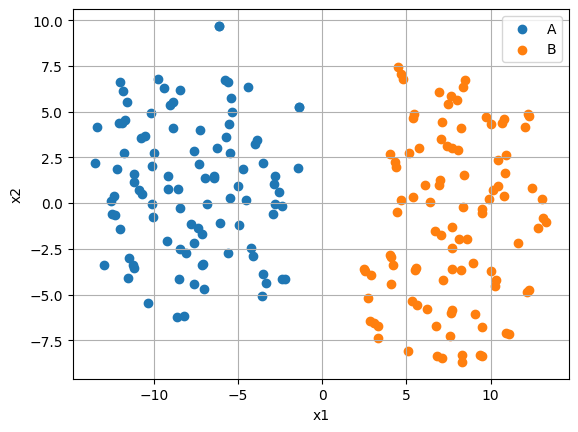

In [31]:
plt.scatter(embedding[:num_points, 0], embedding[:num_points, 1], label = 'A')
plt.scatter(embedding[num_points:, 0], embedding[num_points:, 1], label = 'B')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.legend()
plt.show()

In [32]:
for i in range(50):
    print(divergences[i])

3.6627927887000995
3.6617461328085454
3.654829630074001
3.608972676670582
3.4115659650206416
3.0426721535072967
2.696061486683822
2.4349801006497978
2.23746446648322
2.0890393044879003
1.9781016200960404
1.8921601657730391
1.8186264074847447
1.7639645281001828
1.7228117262102198
1.6877369155947382
1.6578578334064111
1.6304569341867707
1.6060046651508217
1.5842479973786727
1.5639486479343008
1.5475706698071
1.535409964140948
1.5233352098325068
1.5111994794346693
1.5011567808859618
1.4930587452707593
1.4855242457453697
1.478150935700532
1.4714055106354402
1.465644731262402
1.4603543204007567
1.4551158797159554
1.450133072212101
1.445594117121692
1.441415311248602
1.4374852037593893
1.4337805279529898
1.4303186361509412
1.427082451556089
1.4240035612007058
1.4210487938225906
1.418225439494738
1.4155276569508997
1.4129285145706227
1.410408224363731
1.4079623893700794
1.405590338072537
1.4032894273157466
1.4010519008487756


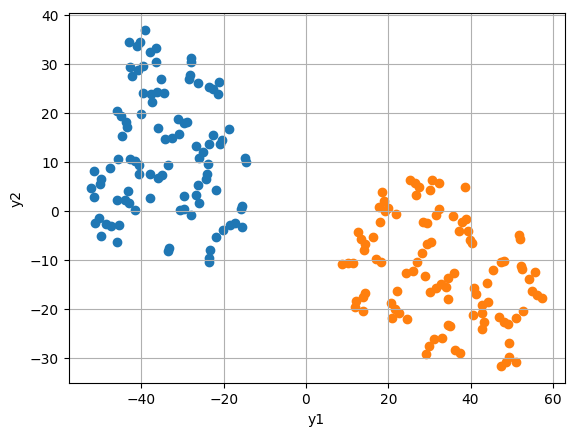

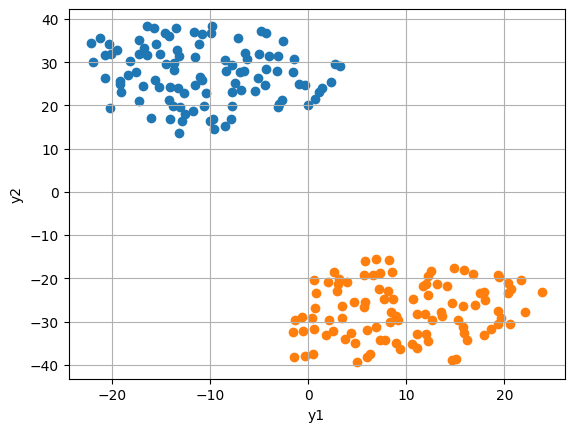

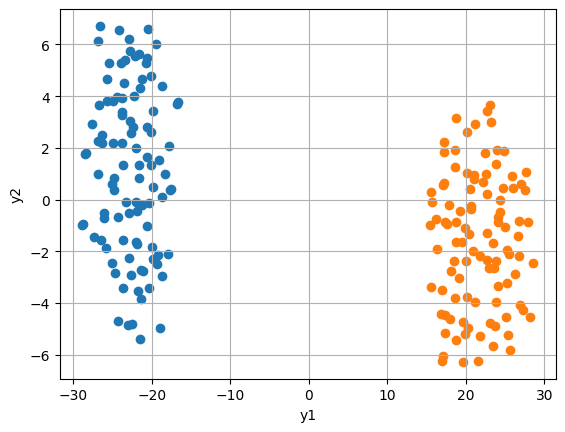

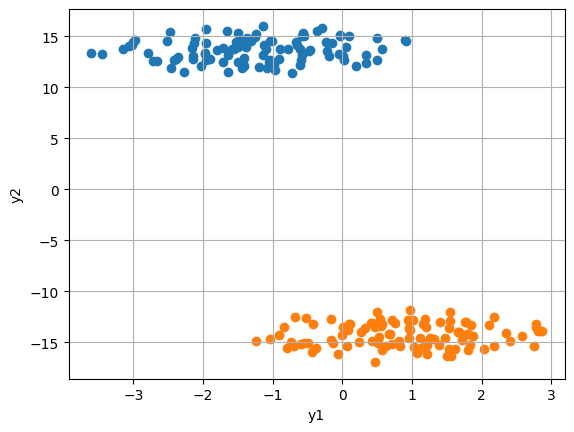

In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

perplexities = [5, 12, 25, 50]

for i, perplexity in enumerate(perplexities):
    embeds = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity).fit_transform(data) 
    plt.scatter(embeds[:num_points, 0], embeds[:num_points, 1], label='A')
    plt.scatter(embeds[num_points:, 0], embeds[num_points:, 1], label='B')
    plt.xlabel('y1')
    plt.ylabel('y2')
    plt.grid(True)
    plt.show()

In t-SNE, perplexity determines how many nearby points are considered as neighbors when calculating similarities between points (line 6 of the algorithm). A smaller perplexity makes the algorithm focus on only a few close points, leading to more spread-out clusters. As perplexity increases, more distant points are treated as similar, causing the pairwise attraction between points to weaken, and the clusters become tighter and more compact. Essentially, a higher perplexity considers a larger neighborhood around each point.